In [1]:
%run -i /eos/user/n/nkarast/myLibrary/init.ipynb

Version 0.03. This is the latest version.
Please help me to improve it reporting bugs to guido.sterbini@cern.ch.
Your platform is Linux-3.10.0-693.11.6.el7.x86_64-x86_64-with-redhat-6.9-Carbon
Your folder is /eos/user/n/nkarast/lumimod
Your IP is 172.17.0.7
2018-06-12 14:52:12


In [2]:
from scipy.constants import c

In [3]:
def getEmittancesFromLumi(LAT, LCMS, beta, bunch_length1, bunch_length2, xing, N1, N2, nb, frev, gamma):
    sigz = (bunch_length1+bunch_length2)/2.0
    p = np.pi
    enx = (-16*gamma*p**2*sigz**4*xing**4*LAT**2*LCMS**2 + frev**2*gamma*N1**2*N2**2*nb**2*(-LAT**2+LCMS**2) + beta*np.sqrt((gamma**2*(64*frev**2*N1**2*N2**2*nb**2*p**2*sigz**4*xing**4*LAT**2*LCMS**4+(frev**2*N1**2*N2**2*nb**2*LCMS**2-LAT**2*(frev**2*N1**2*N2**2*nb**2+16*p**2*sigz**4*xing**4*LCMS**2))**2))/beta**2)) /(32*beta*p**2*sigz**2*xing**2*LAT**2*LCMS**2)
    eny = (2*frev**2*gamma**2*N1**2*N2**2*nb**2*sigz**2*xing**2*LAT**2)/(beta*(16*gamma*p**2*sigz**4*xing**4*LAT**2*LCMS**2+frev**2*gamma*N1**2*N2**2*nb**2*(-LAT**2+LCMS**2)+beta*np.sqrt(gamma**2*(64*frev**2*N1**2*N2**2*nb**2*p**2*sigz**4*xing**4*LAT**2*LCMS**4+(frev**2*N1**2*N2**2*nb**2*LCMS**2-LAT**2*(frev**2*N1**2*N2**2*nb**2+16*p**2*sigz**4*xing**4*LCMS**2))**2)/beta**2)))
    return enx,eny

In [4]:
LAT  = 8.65010502e34
LCMS = 8.63010502e34
nb = 1
frev = 11245.5
gamma = 6927.63
N1 = 1.147e11
N2 = 1.142e11
blen1 = 0.081224
blen2 = 0.081224
beta=0.3
xing=161.0e-6

In [5]:
getEmittancesFromLumi(LAT, LCMS, beta, blen1, blen2, xing, N1, N2, nb,frev, gamma)

(1.722943806091367e-06, 1.7344503229299897e-06)

In [6]:
flist = [int(x.split('_')[-1]) for x in glob.glob('/eos/project/l/lhc-lumimod/LuminosityFollowUp/2018/procdata/'+"*")]

In [7]:
gamma = 6927.63
frev  = 11245.5
nb    = 1

fills         = []
enx_bsrt_mean = []
eny_bsrt_mean = []
enx_bsrt_std  = []
eny_bsrt_std  = []

enx_lumi_mean = []
eny_lumi_mean = []
enx_lumi_std  = []
eny_lumi_std  = []

filled_slots  = []

for filln in flist:
    try:
        with gzip.open("/eos/project/l/lhc-lumimod/LuminosityFollowUp/2018/procdata/fill_{}/fill_{}_lumi_meas.pkl.gz".format(filln, filln), 'rb') as fid:
            meas = pickle.load(fid)
        with gzip.open("/eos/project/l/lhc-lumimod/LuminosityFollowUp/2018/procdata/fill_{}/fill_{}.pkl.gz".format(filln, filln), 'rb') as fid:
            sb = pickle.load(fid)
    except:
        print 'Skipping file: {}'.format(filln)
        continue
    print 'Working on fill {}'.format(filln)

    
    filled_slots.append(len(sb['slots_filled_coll'][1])+len(sb['slots_filled_noncoll'][1]))
    
    intens_b1 = np.array(sb['b_inten_interp_coll'][1][0])
    intens_b2 = np.array(sb['b_inten_interp_coll'][2][0])
    
    blen_b1 = np.array(sb['bl_interp_m_coll'][1][0])
    blen_b2 = np.array(sb['bl_interp_m_coll'][2][0])
    
    
    en1h = np.array(sb['eh_interp_coll'][1][0])
    en1v = np.array(sb['ev_interp_coll'][1][0])
    en2h = np.array(sb['eh_interp_coll'][2][0])
    en2v = np.array(sb['ev_interp_coll'][2][0])
    
    beta     = sb['betastar'][1][0]
    xing_1   = sb['xing_angle'][1][0]
    xing_5   = sb['xing_angle'][5][0]
    xing     = (xing_1+xing_5)/2.0
    
    emit_x_conv_lumi = []
    emit_y_conv_lumi = []
    
    emit_x_conv_data = []
    emit_y_conv_data = []
    
    for i_slot in xrange(len(meas['ATLAS']['bunch_lumi'][0])):
        LAT  = meas['ATLAS']['bunch_lumi'][0][i_slot]
        LCMS = meas['CMS']['bunch_lumi'][0][i_slot]

        tmp_enx, tmp_eny = getEmittancesFromLumi(LAT, LCMS, beta/100., blen_b1[i_slot], blen_b2[i_slot], xing/2.0, intens_b1[i_slot], intens_b2[i_slot], nb , frev, gamma)
        if i_slot == 1:
            print en1h[i_slot], en1v[i_slot],en2h[i_slot], en2v[i_slot], '|', LAT, LCMS, beta/100., blen_b1[i_slot], blen_b2[i_slot], xing/2.0, intens_b1[i_slot], intens_b2[i_slot], nb , frev, gamma, '==>', tmp_enx, tmp_eny
        emit_x_conv_lumi.append(tmp_enx)
        emit_y_conv_lumi.append(tmp_eny)
        
        conv_x = (en1h[i_slot] + en2h[i_slot])/2.0
        conv_y = (en1v[i_slot] + en2v[i_slot])/2.0
        emit_x_conv_data.append(conv_x)
        emit_y_conv_data.append(conv_y)
    
    
    fills.append(filln)        
    enx_bsrt_mean.append(np.nanmean(emit_x_conv_data))
    eny_bsrt_mean.append(np.nanmean(emit_y_conv_data))
    enx_bsrt_std.append(np.nanstd(emit_x_conv_data))
    eny_bsrt_std.append(np.nanstd(emit_y_conv_data))
    
    enx_lumi_mean.append(np.nanmean(emit_x_conv_lumi)*1.0e6)
    eny_lumi_mean.append(np.nanmean(emit_y_conv_lumi)*1.0e6)
    enx_lumi_std.append(np.nanstd(emit_x_conv_lumi)*1.0e6)
    eny_lumi_std.append(np.nanstd(emit_y_conv_lumi)*1.0e6)
        
print('done')  
fills         = np.array(fills        )
enx_bsrt_mean = np.array(enx_bsrt_mean)
eny_bsrt_mean = np.array(eny_bsrt_mean)
enx_bsrt_std  = np.array(enx_bsrt_std )
eny_bsrt_std  = np.array(eny_bsrt_std )

enx_lumi_mean = np.array(enx_lumi_mean)
eny_lumi_mean = np.array(eny_lumi_mean)
enx_lumi_std  = np.array(enx_lumi_std )
eny_lumi_std  = np.array(eny_lumi_std )

filled_slots  = np.array(filled_slots )
        

Working on fill 6570
1.63950736713 1.74557525603 0.88971557269 1.68401325764 | 7.58625125885e+34 7.877816e+34 0.3 0.0819397492114 0.0810841509652 0.00016 110899308400.0 105439072800.0 1 11245.5 6927.63 ==> 1.82352747366e-06 1.63586727832e-06
Working on fill 6573
-1.35261407342 -1.04179846222 -2.65649796239 -1.20181361125 | 4.33179998398e+34 3.918413e+34 0.3 0.0811131742599 0.0807690270242 0.00016 127790992800.0 117559112800.0 1 11245.5 6927.63 ==> 4.52698489121e-06 7.47276891976e-06
Working on fill 6574
2.37995785068 2.95573074367 1.24298898809 2.26184804385 | 7.32044363022e+34 6.323882e+34 0.3 0.0815218414261 0.0785568108483 0.00016 134407388600.0 107673242467.0 1 11245.5 6927.63 ==> 2.22282959606e-06 3.72123806533e-06
Working on fill 6579
1.86828322631 2.14084307152 0.99685838155 1.96054517822 | 7.79616546631e+34 8.237477e+34 0.3 0.0803381176752 0.0794585031519 0.00016 112210182917.0 111237367000.0 1 11245.5 6927.63 ==> 2.00049117354e-06 1.69802349471e-06
Working on fill 6583
2.71219

Working on fill 6659
1.91085375064 1.59331387397 2.68769336823 1.59384915016 | 7.07718896866e+34 7.210922e+34 0.3 0.0805174801181 0.0815922438166 0.00016 106436517500.0 102780039500.0 1 11245.5 6927.63 ==> 1.81973654826e-06 1.72319542842e-06
Working on fill 6662
2.01568692145 1.61197107661 2.54370217154 1.55905338049 | 7.75524330139e+34 7.894303e+34 0.3 0.0818918941149 0.0828592358898 0.00016 108820815600.0 110024154200.0 1 11245.5 6927.63 ==> 1.78363576982e-06 1.69503263427e-06
Working on fill 6663
2.13535997282 1.77936182172 2.88080841927 1.70897096963 | 7.64317798615e+34 7.623003e+34 0.3 0.0828871161048 0.0813393277777 0.00016 108849827967.0 110910871267.0 1 11245.5 6927.63 ==> 1.82805619449e-06 1.84222333959e-06
Working on fill 6666
1.94691193123 1.65250380537 2.74822698244 1.58346957832 | 7.56867170334e+34 7.689464e+34 0.3 0.0848337768468 0.0807350199216 0.00016 109401499300.0 107442916150.0 1 11245.5 6927.63 ==> 1.78809160066e-06 1.70884591193e-06
Working on fill 6672
1.954627319

Working on fill 6751
1.9661594619 1.57000926618 1.08858594873 1.46329062281 | 7.35168266296e+34 7.295169e+34 0.3 0.0877388670656 0.0829530291033 0.00016 103222654400.0 105943372200.0 1 11245.5 6927.63 ==> 1.59268944376e-06 1.62682025521e-06
Working on fill 6752
1.88964594787 1.53777745399 1.26027576517 1.60176265057 | 7.34755754471e+34 7.24665e+34 0.3 0.0831471112027 0.0810220832886 0.00016 103169039267.0 103349048267.0 1 11245.5 6927.63 ==> 1.59424979217e-06 1.65756284591e-06
Working on fill 6755
1.91539198836 1.50315054525 1.35155312125 1.63311633487 | 6.89936542511e+34 6.71033e+34 0.3 0.0819319529151 0.0791125917343 0.00016 99231592700.0 100768524300.0 1 11245.5 6927.63 ==> 1.60883377528e-06 1.74254396487e-06
Working on fill 6757
2.0095755813 1.55809966309 1.44464236821 1.70899741965 | 7.4204302152e+34 7.38523e+34 0.3 0.0824891261437 0.0804970519215 0.00016 107947322100.0 105514251100.0 1 11245.5 6927.63 ==> 1.7614573067e-06 1.78594526513e-06
Working on fill 6759
1.91745716893 1.538

/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in double_scalars
/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1308: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')


In [8]:
from matplotlib.ticker import MaxNLocator

/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


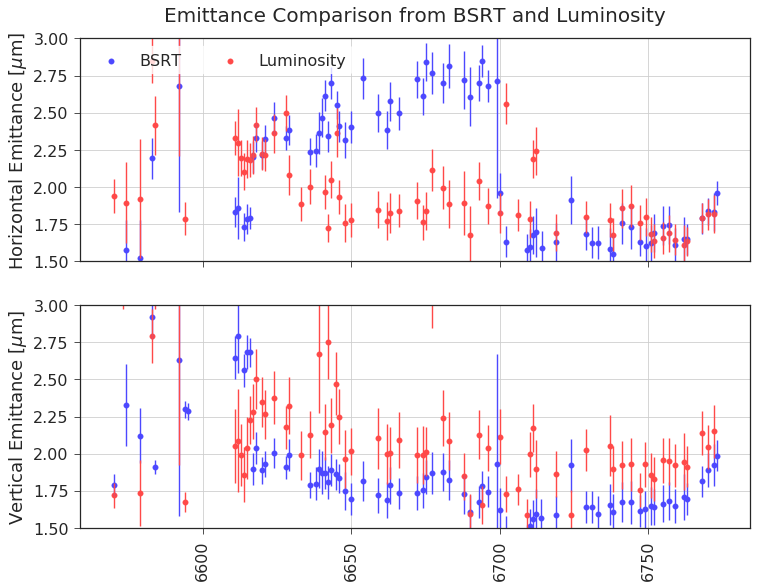

In [9]:
fig = plt.figure(1, figsize=(12,9))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)

ax1.errorbar(fills, enx_bsrt_mean, yerr=enx_bsrt_std, c='#4C48FF', ls='None')
ax1.errorbar(fills, enx_lumi_mean, yerr=enx_lumi_std, c='#FF4948', ls='None')

ax1.scatter(fills, enx_bsrt_mean, c='#4C48FF', label='BSRT')
ax1.scatter(fills, enx_lumi_mean, c='#FF4948', label='Luminosity')
    

ax2.errorbar(fills, eny_bsrt_mean, yerr=eny_bsrt_std, c='#4C48FF', ls='None')
ax2.errorbar(fills, eny_lumi_mean, yerr=eny_lumi_std, c='#FF4948', ls='None')

ax2.scatter(fills, eny_bsrt_mean, c='#4C48FF', label='BSRT')
ax2.scatter(fills, eny_lumi_mean, c='#FF4948', label='Luminosity')

ax1.set_ylim(1.5, 3)
ax2.set_ylim(1.5, 3)


ax1.set_ylabel('Horizontal Emittance [$\mu$m]', fontsize=18)
ax2.set_ylabel('Vertical Emittance [$\mu$m]', fontsize=18)
ax1.set_title("Emittance Comparison from BSRT and Luminosity", fontsize=20, y=1.05)

# ax1.axvline(6617, lw=3, c='k', zorder=2)
# ax2.axvline(6617, lw=3, c='k', zorder=2)
# ax1.axvspan(fills[0], 6617, color='gray', alpha=0.2, zorder=2)
# ax2.axvspan(fills[0], 6617, color='gray', alpha=0.2, zorder=2)
# ax1.axvspan(6643, fills[-1], color='#e51919', alpha=0.1, zorder=100, label='2556b')
# ax2.axvspan(6643, fills[-1], color='#e51919', alpha=0.1, zorder=100, label='2556b')
# ax1.axvspan(6640, 6642, color='#e58918', alpha=0.1, zorder=100, label='2460b')
# ax2.axvspan(6640, 6642, color='#e58918', alpha=0.1, zorder=100, label='2460b')




leg = ax1.legend(loc='upper left', frameon=True, fancybox=True, ncol=2)
frame = leg.get_frame()
frame.set_color('white')
# ax2.xaxis.set_major_locator(MaxNLocator(50))

ax1.grid('on')
ax2.grid('on')
plt.setp(ax1.get_xticklabels(), visible=False, rotation=90);
plt.setp(ax1.get_yticklabels(), fontsize=16);
plt.setp(ax2.get_xticklabels(), fontsize=16, visible=True, rotation=90);
plt.setp(ax2.get_yticklabels(), fontsize=16, visible=True);


In [ ]:
plt.plot(enx_bsrt_mean)
plt.plot(eny_bsrt_mean)
plt.ylim(1,4)

In [ ]:
np.linspace(fills[0], fills[-1], fills[-1]-fills[0]+1)

In [ ]:
ax1.get_xticks()

In [ ]:
#1.94691193123 1.65250380537 | 7.56867170334e+34 7.689464e+34 0.3 0.0848337768468 0.0807350199216 0.00016 109401499300.0 107442916150.0 1 11245.5 6927.63 ==> 1.78809160066e-06 1.70884591193e-06
# 2.1427714294 1.79194157469 | 7.25952243805e+34 2.840644e+34 0.3 0.081845256321 0.0823096981817 0.00016 109202704650.0 106525579550.0 1 11245.5 6927.63 ==> 5.54746014806e-07 1.5784003854e-05
def lumi(enx, eny, n1, n2, nb, beta, xing, bl1, bl2, frev, gamma, exp='ATLAS'):
    if exp=='ATLAS':
        ecross = eny
    else:
        ecross = enx
    sigz = (bl1+bl2)/2.
    L = n1*n2*nb*frev/(4.0*np.pi*np.sqrt(beta*enx/gamma)*np.sqrt(beta*eny/gamma))*1/np.sqrt(1+(sigz/np.sqrt(beta*ecross/gamma)*xing)**2)
    return L


In [ ]:
lumi(5.54746014806e-07, 1.5784003854e-05, 109202704650.0, 106525579550.0, 1, 0.3, 161e-6, 0.081845256321, 0.0823096981817, 11245.5, 6927.63, exp='CMS')

In [ ]:
gamma = 6927.63
frev  = 11245.5
nb    = 1

fills         = []
# enx_bsrt_mean = []
# eny_bsrt_mean = []
# enx_bsrt_std  = []
# eny_bsrt_std  = []

# enx_lumi_mean = []
# eny_lumi_mean = []
# enx_lumi_std  = []
# eny_lumi_std  = []

elumi = []
ebsrt = []

filled_slots  = []

for filln in flist[:1]:
    try:
        with gzip.open("/eos/project/l/lhc-lumimod/LuminosityFollowUp/2018/procdata/fill_{}/fill_{}_lumi_meas.pkl.gz".format(filln, filln), 'rb') as fid:
            meas = pickle.load(fid)
        with gzip.open("/eos/project/l/lhc-lumimod/LuminosityFollowUp/2018/procdata/fill_{}/fill_{}.pkl.gz".format(filln, filln), 'rb') as fid:
            sb = pickle.load(fid)
    except:
        print 'Skipping file: {}'.format(filln)
        continue
    print 'Working on fill {}'.format(filln)
    
    elumi_tmp = []
    ebsrt_tmp = []
    
    for i_slot in xrange(len(sb['slots_filled_coll'][1])):
        print gamma, (sb['betastar'][1][1]/100.), sb['b_inten_interp_coll'][1][1][i_slot], sb['b_inten_interp_coll'][2][1][i_slot], frev, ((meas['ATLAS']['bunch_lumi'][1][i_slot])+(meas['CMS']['bunch_lumi'][1][i_slot]))/2.0
        lmean = ((meas['ATLAS']['bunch_lumi'][1][i_slot])+(meas['CMS']['bunch_lumi'][1][i_slot]))/2.0
        print (gamma/(4.*lmean*np.pi*sb['betastar'][1][1]/100.)) * sb['b_inten_interp_coll'][1][1][i_slot]*sb['b_inten_interp_coll'][2][1][i_slot]*frev
        elumi_tmp.append(gamma/(sb['betastar'][1][1]/100.) * (( sb['b_inten_interp_coll'][1][1][i_slot]*sb['b_inten_interp_coll'][2][1][i_slot]*frev )/4*np.pi*((meas['ATLAS']['bunch_lumi'][1][i_slot])+(meas['CMS']['bunch_lumi'][1][i_slot]))/2.0))
        ebsrt_tmp.append(((sb['eh_interp_coll'][1][1][i_slot]+sb['ev_interp_coll'][1][1][i_slot])/2 + (sb['eh_interp_coll'][2][1][i_slot]+sb['ev_interp_coll'][2][1][i_slot])/2 )/2.0)
        
        print (gamma/(4.*lmean*np.pi*sb['betastar'][1][1]/100.)) * sb['b_inten_interp_coll'][1][1][i_slot]*sb['b_inten_interp_coll'][2][1][i_slot]*frev
        print ((sb['eh_interp_coll'][1][1][i_slot]+sb['ev_interp_coll'][1][1][i_slot])/2 + (sb['eh_interp_coll'][2][1][i_slot]+sb['ev_interp_coll'][2][1][i_slot])/2 )/2.0
        
        
        
    
    elumi_tmp = np.array(elumi_tmp)
    ebsrt_tmp = np.array(ebsrt_tmp)
    
    elumi.append(elumi_tmp)
    ebsrt.append(ebsrt_tmp)

elumi = np.array(elumi)
ebsrt = np.array(ebsrt)

print('done')

